In [1]:
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tools_edmz.atlas import Atlas
from tools_edmz.process_df import count_cells, group_counts, collapse_structures, filter_df, normalize_df

atlas = Atlas(json_version="clearmap")

In [13]:
FOLDER_DATA = "/home/etienne.doumazane/data/AnaMarta/"
FOLDER_FIGS = "/home/etienne.doumazane/figures/Anamarta/20220927/"

In [16]:
[fname for fname in os.listdir(FOLDER_DATA) if fname.endswith('feather')]

['727.feather',
 '726.feather',
 '761.feather',
 '728.feather',
 '769.feather',
 '763.feather',
 '725.feather',
 '768.feather']

In [ ]:
fnames = ['727.feather',
 '726.feather',
 '761.feather',
 '728.feather',
 '769.feather',
 '763.feather',
 '725.feather',
 '768.feather']

In [18]:
    # set sample source files and corresponding names

map_path_to_sample_name = {
     f'{FOLDER_DATA}726.feather': '726',
     f'{FOLDER_DATA}727.feather': '727',
     f'{FOLDER_DATA}761.feather': '761',
     f'{FOLDER_DATA}728.feather': '728',
     f'{FOLDER_DATA}769.feather': '769',
     f'{FOLDER_DATA}763.feather': '763',
     f'{FOLDER_DATA}725.feather': '725',
     f'{FOLDER_DATA}768.feather': '768',
}

sample_paths = list(map_path_to_sample_name.keys())
sample_names = list(map_path_to_sample_name.values())

path = sample_paths[0] #for debugging

In [19]:
map_path_to_sample_name

{'/home/etienne.doumazane/data/AnaMarta/726.feather': '726',
 '/home/etienne.doumazane/data/AnaMarta/727.feather': '727',
 '/home/etienne.doumazane/data/AnaMarta/761.feather': '761',
 '/home/etienne.doumazane/data/AnaMarta/728.feather': '728',
 '/home/etienne.doumazane/data/AnaMarta/769.feather': '769',
 '/home/etienne.doumazane/data/AnaMarta/763.feather': '763',
 '/home/etienne.doumazane/data/AnaMarta/725.feather': '725',
 '/home/etienne.doumazane/data/AnaMarta/768.feather': '768'}

In [20]:
#Set order used in the plots
sample_names_ordered = ['725', '726', '727', '728', '761', '763', '768', '769', ]

In [21]:
# Set structures of interest
structures_oi = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

In [22]:
# Set structures for normalization. These structures will be the 100% of the counts (number, hemisphere, included/excluded)

norm_structures = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

In [23]:
# Set hemisphere
norm_hemispheres = ['RH'] # or ['LH'] or ['RH', 'LH']

# Set include/exclude
norm_exclude = False # True or False (False means will take as 100% the regions listed,True will take as 100% everything else)

In [43]:
df = pd.read_feather(path).value_counts().reset_index().rename(columns={0:'count'})

In [54]:
structures_oi = df.head(50).id.tolist()[1:]

In [55]:
def count_cells(path: str) -> pd.DataFrame:
    """
    counts cells from one file of type cells.feather
    returns df with columns id, hemisphere, cell_count and one row per structure x hemisphere
    """
    counts = pd.read_feather(path).value_counts().reset_index().rename(columns={0:'count'})
    return counts

def group_counts(counts_s, sample_names) -> pd.DataFrame:
    """
    groups several cell_counts together; sample_names are the names of the samples
    returns df with columns id, hemisphere, and one column per sample
    """
    counts_s = [counts.set_index(['id', ]) for counts in counts_s]
    df = pd.concat(counts_s, axis=1).fillna(0)
    df.columns = sample_names
    df = df.reset_index()
    return df

def collapse_structures(df: pd.DataFrame, map_collapse) -> pd.DataFrame:
    """
    collapses structures according to a dict map_collapse (id -> new_id)
    ids not in map_collapse are kept
    """
    df['id'] = df['id'].map(lambda x: map_collapse.get(x, x))
    counts = (df.groupby(['id', ], as_index=False)
              .sum()
              )
    return counts

def filter_df(df: pd.DataFrame, structure_ids, exclude: bool=False) -> pd.DataFrame:
    """
    returns a df that includes only the
    """
    if exclude is False:
        df = df.loc[df["id"].isin(structure_ids) ].reset_index(drop=True)
        return df.copy()
    else:
        df = df.loc[~(df["id"].isin(structure_ids))].reset_index(drop=True)
        return df.copy()

def normalize_df(df: pd.DataFrame, df_normalize: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index(['id']).copy()
    df_normalize = df_normalize.set_index(['id']).copy()
    normalize_100 = df_normalize.sum(axis=0)
    df = df/normalize_100 * 100
    return df.reset_index()


In [57]:
# transform cells.feather into cell_count dataframes
counts = [count_cells(path,) for path in sample_paths]
# regroup all samples in one table ('id', 'hemisphere' and sample_names)
table = group_counts(counts, sample_names)

# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)
# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(collapsed_table, structures_oi)


In [58]:
# finally, get the annotation
final_table = atlas.enrich_df(filtered_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))
#### Save
final_table.to_csv(FOLDER_FIGS + 'example_1.csv')

In [60]:
final_table

,id,726,727,761,728,769,763,725,768,name,acronym
16,811,116677.0,176493.0,87753.0,122791.0,109292.0,108742.0,146237.0,61883.0,"Inferior colliculus, central nucleus",ICc
20,829,106064.0,121935.0,41521.0,95772.0,79906.0,45765.0,108849.0,32050.0,"Subiculum, dorsal part, molecular layer",SUBd-m
23,876,103906.0,142592.0,114056.0,114265.0,91947.0,132352.0,147672.0,90203.0,accessory optic tract,aot
14,799,86122.0,152447.0,94094.0,88443.0,58377.0,98221.0,102495.0,84733.0,Dentate gyrus medial blade,DGmb
18,817,78849.0,164190.0,117141.0,104602.0,122717.0,156385.0,115888.0,77208.0,"supraoptic commissures, anterior",supa
12,724,76969.0,124751.0,97217.0,77396.0,71873.0,97061.0,96349.0,81781.0,"Anterior hypothalamic nucleus, posterior part",AHNp
22,841,66623.0,88368.0,48973.0,65944.0,126524.0,24525.0,78326.0,8617.0,trapezoid body,tb
37,1180,65835.0,100239.0,48957.0,54972.0,37645.0,73757.0,85418.0,41463.0,NaN,NaN
1,389,55757.0,6046.0,72545.0,53655.0,34311.0,42126.0,51781.0,32139.0,ventral spinothalamic tract,sttv
11,650,51820.0,56854.0,18457.0,48705.0,18641.0,22139.0,53264.0,15423.0,juxtarestiform body,jrb


In [67]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                #square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,  ### Tweek that 
                vmin=0,     ### Tweek that 
                annot=True,
                #fmt='.1f',
                annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);


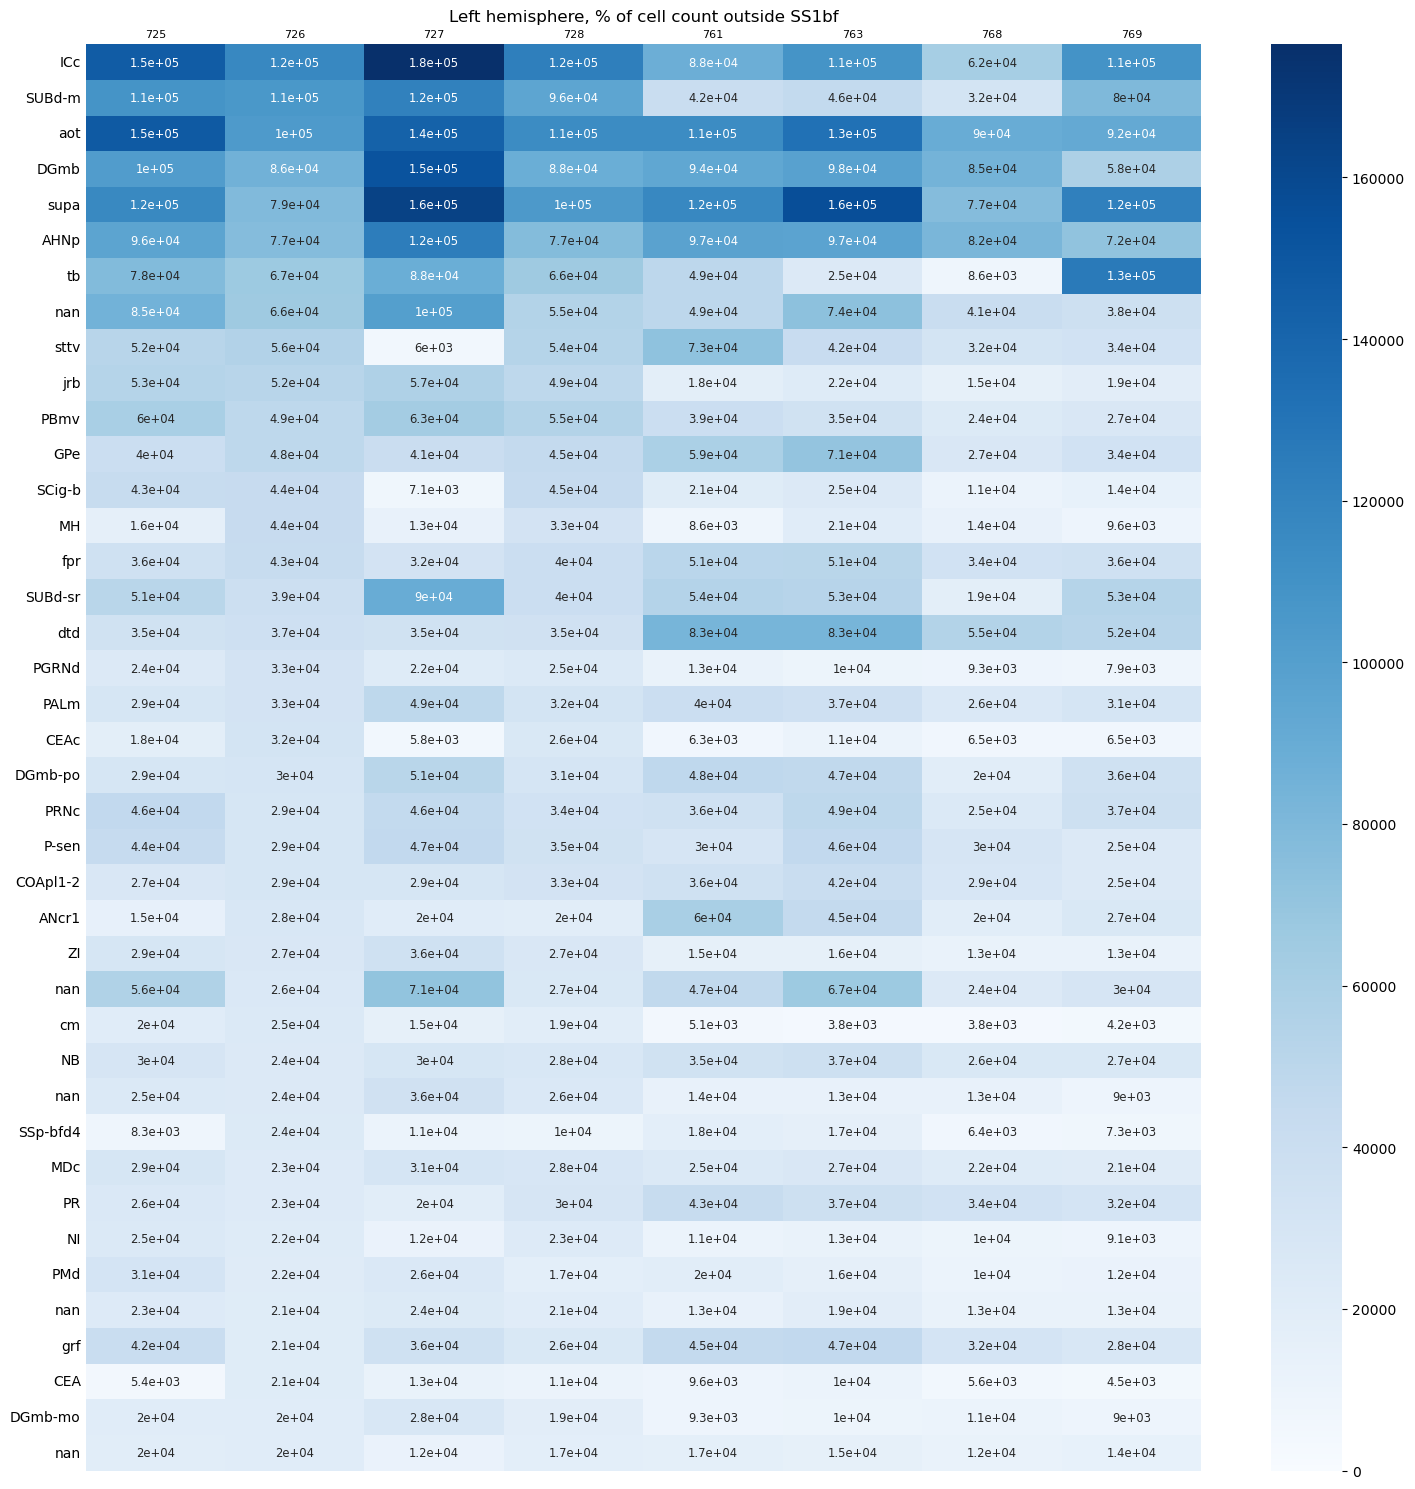

In [68]:
plt.figure(figsize=(15, 15))
plot_heatmap(final_table, sample_names_ordered,  "Blues",)
plt.title('Left hemisphere, % of cell count outside SS1bf')
plt.tight_layout()
plt.savefig(FOLDER_FIGS + 'toto.svg')

In [ ]:
atlas.get